In [4]:
# import traja
# Python code for 2D random walk.
import matplotlib.pyplot as plt
import pylab
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
import pickle
from utils.plotting import plot_trajectory
from utils.processing import (
    open_file,
    normalize_angles_2pi,
    open_preprocessed_data,
)

In [5]:
30 * 60 / 0.3

6000.0

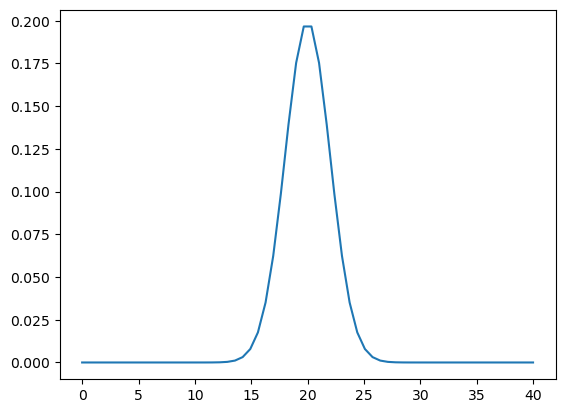

In [5]:
prob_x = np.linspace(0, 40, 60)
prob_y = norm.pdf(prob_x, 20, 2)
plt.plot(prob_x, prob_y)

In [7]:
dl = random.choices(prob_x, prob_y, k = 1)[0]

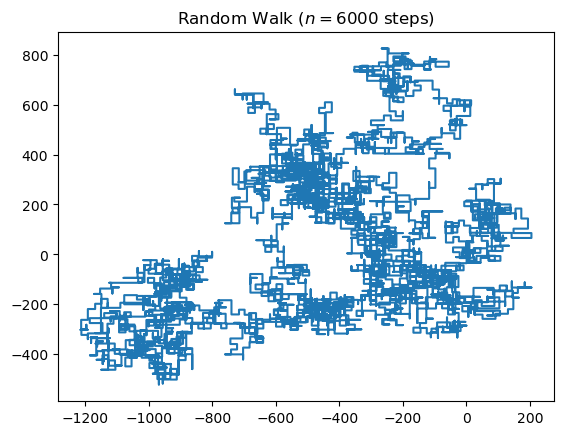

In [32]:
# defining the number of steps
# n = 6000
n = 6000
 
#creating two array for containing x and y coordinate
#of size equals to the number of size and filled up with 0's
x = np.zeros(n)
y = np.zeros(n)
 
# filling the coordinates with random variables
for i in range(1, n):
    val = random.randint(1, 4)
    if val == 1:
        x[i] = x[i - 1] + random.choices(prob_x, prob_y, k = 1)[0]
        y[i] = y[i - 1]
    elif val == 2:
        x[i] = x[i - 1] - random.choices(prob_x, prob_y, k = 1)[0]
        y[i] = y[i - 1]
    elif val == 3:
        x[i] = x[i - 1]
        y[i] = y[i - 1] + random.choices(prob_x, prob_y, k = 1)[0]
    else:
        x[i] = x[i - 1]
        y[i] = y[i - 1] - random.choices(prob_x, prob_y, k = 1)[0]
    #a=1

 

pylab.title("Random Walk ($n = " + str(n) + "$ steps)")
pylab.plot(x, y)
# # pylab.savefig("rand_walk"+str(n)+".png",bbox_inches="tight",dpi=600)
pylab.show()

In [10]:
# np.arange(0, 1800, 0.3)

In [12]:
df = pd.DataFrame(list(zip(np.arange(0, 1800, 0.3),x, y)),columns =['time','x', 'y'])

In [13]:
dfs_like = {1: df}

In [14]:
# 3. rescale x and y coords to fit area size 
# может добавить функцию rescale_coord в processing.py? TODO
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_like.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

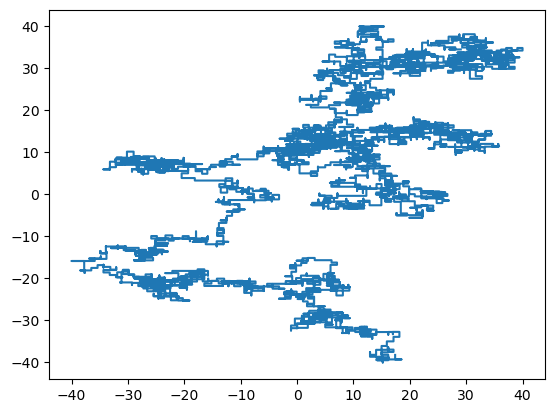

In [15]:
plt.plot(rescaled_dfs_dict[1]['x'],rescaled_dfs_dict[1]['y'])

In [16]:
# add angles, delta_angles, step len, 
def add_angles(df):
    dt = df['time'].diff()
    vvx = df['x'].diff() / dt 
    vvy = df['y'].diff() / dt 
    dt[0], vvx[0], vvy[0] = 0., 0., 0.

    Xx = np.arctan2(vvx, vvy)
    Nres = normalize_angles_2pi(Xx)
    ang = np.rad2deg(Nres) % 360
    df['angles'] = ang
    return df

def add_delta_angles(df):
    dangles = df['angles'].diff()
    dangles[0] = 0.
    dangles_rad = np.deg2rad(dangles)
    normed_dangels_rad = normalize_angles_2pi(dangles_rad)
    df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
    return df

def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,
    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dict_angles = {}
for a, d in rescaled_dfs_dict.items():
    df_ang = add_angles(d)
    df_dt_ang = add_delta_angles(df_ang)
    df_step = add_step_length(df_dt_ang)
    dict_angles[a] = df_step

# sort by areas of open field
#долго выполняется если рисовать все графики


def sort_walls_area(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 40
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 30
            else:
                tr['near_wall'].iloc[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 10
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 20
            else:
                tr['near_wall'].iloc[i] = 2
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 1
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 3
    return tr

def plot_wall_sorted_samples(df, plot_title):
    all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
    for a in all_areas:
        x = df.loc[df['near_wall'] == a]['x']
        y = df.loc[df['near_wall'] == a]['y']
        plt.scatter(x, y, s=1.5, label=str(a))
    plt.gca().set_aspect('equal')
    plt.title(plot_title)
    plt.legend(loc='center')
    plt.show()


wall_perc = 0.1
dict_walls = {}
bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40}  
for a, d in dict_angles.items():
    df = sort_walls_area(d, bord40, wall_perc)
    #plot_wall_sorted_samples(sub_df, k)
    dict_walls[a] = df

In [17]:
with open('gaus_random2d.pickle', 'wb') as handle:
    pickle.dump(dict_walls, handle)

## distributions

In [18]:
#отмена (убираем паузы т к их не учитываем для распределний. параметр 0.5 т к используемый вероятности паузы основаны на max_step_of_stop = 1 и window_size = 2) 
#(data_preprocessing+DeltaDirections01_checked_Copy1.ipynb)
def merge_df_1d(df_dict, areas_list):
    delta_ang_list = []
    for k, df in df_dict.items():
        df_ar = df.loc[df['near_wall'].isin(areas_list)]
        #df_ar = df_ar.loc[df_ar['step_length']>=0.5]
        delta_ang_list.append(df_ar)
    dfN = pd.concat(delta_ang_list)
    dfN = dfN.reset_index(drop=True)
    return dfN

In [19]:
model_all_merge = {}
model_all_merge['corner'] = merge_df_1d(dict_walls, [10, 20, 30, 40])
model_all_merge['wall'] = merge_df_1d(dict_walls, [1, 2, 3, 4])
model_all_merge['center'] = merge_df_1d(dict_walls, [0])

In [ ]:
# bins = 60

# # #made df for every zone (corners, center, walls)
# # aver_delta_angles = {}

# # aver_corner = merge_df(near_corner_dict)
# # print(f'For area corner df len={len(aver_corner)}')
# # aver_delta_angles['corner'] = aver_corner['delta_angle']

# # aver_wall = merge_df(near_wall_dict)
# # print(f'For area wall df len={len(aver_wall)}')
# # aver_delta_angles['wall'] = aver_wall['delta_angle']

# # aver_center = merge_df(near_center_dict)
# # print(f'For area center df len={len(aver_center)}')
# # aver_delta_angles['center'] = aver_center['delta_angle']

# #all normalized
# def min_max_normalize(y):
#     yn = (y - y.min()) / (y.max() - y.min())
#     return yn


# fig, axes = plt.subplots(1, 3, figsize=(14, 4))
# delta_ang_hist = {}

# freqs, binEdges, _ = axes[0].hist(model_all_merge['corner']['delta_angle'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['corner']  = [bin_mid, freqs]
# axes[0].plot(bin_mid, freqs)
# axes[0].set_title(f'London model, all corners [10, 20, 30, 40], bins={bins}')

# freqs, binEdges, _ = axes[1].hist(model_all_merge['wall']['delta_angle'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['wall']  = [bin_mid, freqs]
# axes[1].plot(bin_mid, freqs)
# axes[1].set_title(f'London model, all walls [1, 2, 3, 4], bins={bins}')

# freqs, binEdges, _ = axes[2].hist(model_all_merge['center']['delta_angle'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['center']  = [bin_mid, freqs]
# axes[2].plot(bin_mid, freqs)
# axes[2].set_title(f'London model, center [0], bins={bins}')

# plt.figure(figsize=(8,4))
# for k, l in delta_ang_hist.items():
#     l[1] = min_max_normalize(l[1])
#     plt.plot(l[0], l[1], label=k)
# plt.title('Delta directions distributions in different areas')
# plt.legend()
# plt.show()

# # Save distributions
# # import pickle
# # with open(f'model_london_delt_ang_distr_0_3_s_bins_{bins}.pkl', 'wb') as fp:    
# #     pickle.dump(delta_ang_hist, fp)

In [20]:
lens = {}
for aa in model_all_merge:
    print(aa)
    print(len(model_all_merge[aa]))
    lens[aa] = len(model_all_merge[aa])

corner
153
wall
893
center
4954


In [21]:
model_all_merge['center'] = model_all_merge['center'].iloc[1:].reset_index(drop=True)

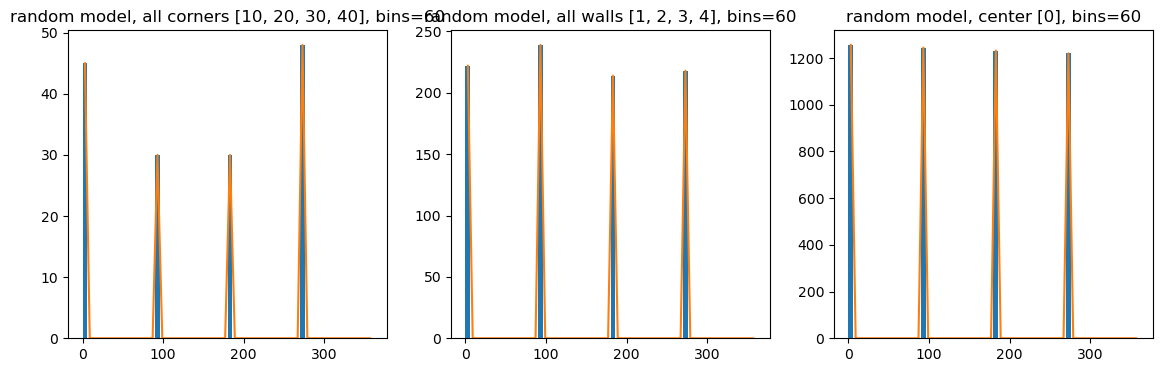

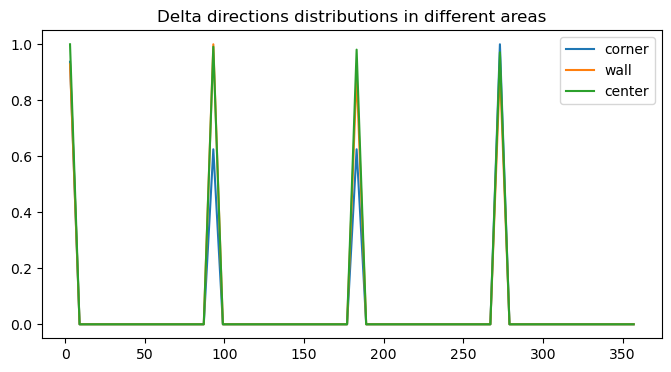

In [27]:
bins = 60

# #made df for every zone (corners, center, walls)
# aver_delta_angles = {}

# aver_corner = merge_df(near_corner_dict)
# print(f'For area corner df len={len(aver_corner)}')
# aver_delta_angles['corner'] = aver_corner['delta_angle']

# aver_wall = merge_df(near_wall_dict)
# print(f'For area wall df len={len(aver_wall)}')
# aver_delta_angles['wall'] = aver_wall['delta_angle']

# aver_center = merge_df(near_center_dict)
# print(f'For area center df len={len(aver_center)}')
# aver_delta_angles['center'] = aver_center['delta_angle']

#all normalized
def min_max_normalize(y):
    yn = (y - y.min()) / (y.max() - y.min())
    return yn


fig, axes = plt.subplots(1, 3, figsize=(14, 4))
delta_ang_hist = {}

freqs, binEdges, _ = axes[0].hist(model_all_merge['corner']['delta_angle'], range=(0, 360), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['corner']  = [bin_mid, freqs]
axes[0].plot(bin_mid, freqs)
axes[0].set_title(f'random model, all corners [10, 20, 30, 40], bins={bins}')

freqs, binEdges, _ = axes[1].hist(model_all_merge['wall']['delta_angle'], range=(0, 360), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['wall']  = [bin_mid, freqs]
axes[1].plot(bin_mid, freqs)
axes[1].set_title(f'random model, all walls [1, 2, 3, 4], bins={bins}')

freqs, binEdges, _ = axes[2].hist(model_all_merge['center']['delta_angle'], range=(0, 360), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['center']  = [bin_mid, freqs]
axes[2].plot(bin_mid, freqs)
axes[2].set_title(f'random model, center [0], bins={bins}')

plt.figure(figsize=(8,4))
for k, l in delta_ang_hist.items():
    l[1] = min_max_normalize(l[1])
    plt.plot(l[0], l[1], label=k)
plt.title('Delta directions distributions in different areas')
plt.legend()
plt.show()

# Save distributions
with open(f'gauss_random_model_delta_angle_0_3_s_bins_{bins}.pkl', 'wb') as fp:    
    pickle.dump(delta_ang_hist, fp)

In [28]:
ang_true_hist = delta_ang_hist.copy()

In [55]:
# fig, axes = plt.subplots(1, 3, figsize=(14, 4))
# delta_ang_hist = {}

# freqs, binEdges, _ = axes[0].hist(model_all_merge['corner']['step_length'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['corner']  = [bin_mid, freqs]
# axes[0].plot(bin_mid, freqs)
# axes[0].set_title(f'random model, all corners [10, 20, 30, 40], bins={bins}')

# freqs, binEdges, _ = axes[1].hist(model_all_merge['wall']['step_length'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['wall']  = [bin_mid, freqs]
# axes[1].plot(bin_mid, freqs)
# axes[1].set_title(f'random model, all walls [1, 2, 3, 4], bins={bins}')

# freqs, binEdges, _ = axes[2].hist(model_all_merge['center']['step_length'], bins=bins)
# bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
# delta_ang_hist['center']  = [bin_mid, freqs]
# axes[2].plot(bin_mid, freqs)
# axes[2].set_title(f'random model, center [0], bins={bins}')

# plt.figure(figsize=(8,4))
# for k, l in delta_ang_hist.items():
#     l[1] = min_max_normalize(l[1])
#     plt.plot(l[0], l[1], label=k)
# plt.title('Step length distributions in different areas')
# plt.legend()
# plt.show()

# # Save distributions
# import pickle
# with open(f'random_step_length_distr_0_3_s_bins_{bins}.pkl', 'wb') as fp:    
#     pickle.dump(delta_ang_hist, fp)

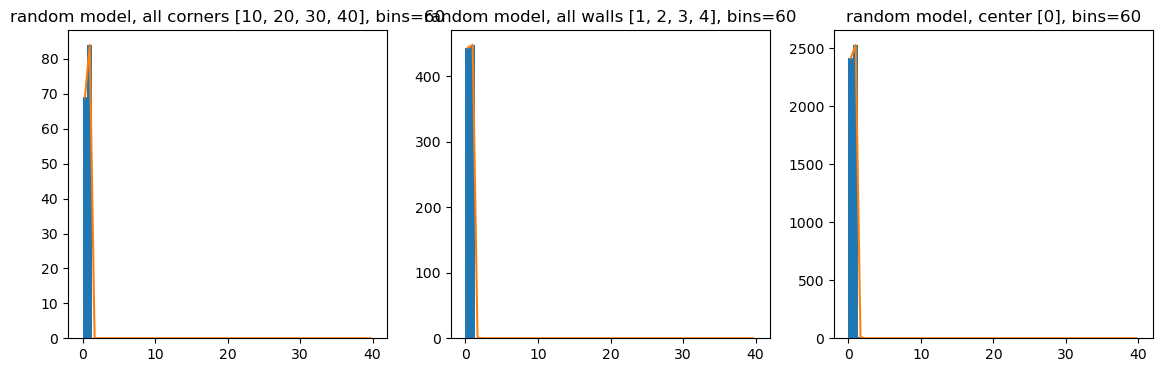

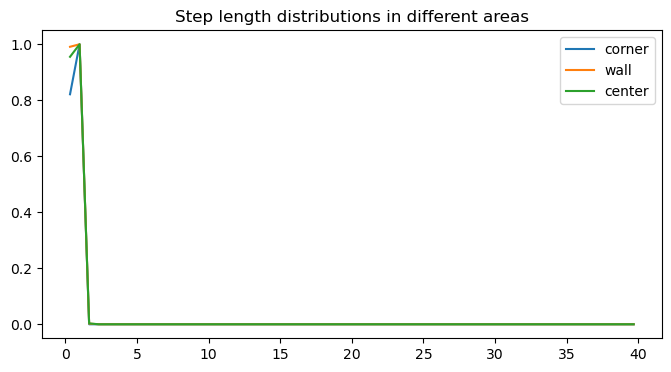

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
delta_ang_hist = {}

freqs, binEdges, _ = axes[0].hist(model_all_merge['corner']['step_length'], range=(0, 40), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['corner']  = [bin_mid, freqs]
axes[0].plot(bin_mid, freqs)
axes[0].set_title(f'random model, all corners [10, 20, 30, 40], bins={bins}')

freqs, binEdges, _ = axes[1].hist(model_all_merge['wall']['step_length'], range=(0, 40), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['wall']  = [bin_mid, freqs]
axes[1].plot(bin_mid, freqs)
axes[1].set_title(f'random model, all walls [1, 2, 3, 4], bins={bins}')

freqs, binEdges, _ = axes[2].hist(model_all_merge['center']['step_length'], range=(0, 40), bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['center']  = [bin_mid, freqs]
axes[2].plot(bin_mid, freqs)
axes[2].set_title(f'random model, center [0], bins={bins}')

plt.figure(figsize=(8,4))
for k, l in delta_ang_hist.items():
    l[1] = min_max_normalize(l[1])
    plt.plot(l[0], l[1], label=k)
plt.title('Step length distributions in different areas')
plt.legend()
plt.show()

#Save distributions
with open(f'gauss_random_step_length_distr_0_3_s_bins_{bins}.pkl', 'wb') as fp:    
    pickle.dump(delta_ang_hist, fp)

In [39]:
# model_all_merge['center']['x']

In [40]:
# model_all_merge['center']['y']

In [41]:
# model_all_merge['center']['step_length']